In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-06')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [5]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_beta_0=0.1, inits='random', iteration=2000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[start:last, country].values
        D0 = death.loc[start:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_beta_0':b_beta_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [8]:
## Compile models ##
sm_const = pystan.StanModel(file="const.stan")
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e016c2803a6aaef99e20fd9e9c81e7a9 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_480ac5eb816fc9bbcdd0b556dd97733b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b305bf3606a6c594794b11744bb1397a NOW.


In [9]:
## Model Validation ##

In [10]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     120.34    1.47  22.24  79.42 104.91 119.45 134.55 166.92    230   1.01
b_beta       2.3e-3  4.4e-4 1.5e-3 3.9e-4 1.1e-3 2.0e-3 3.0e-3 6.0e-3     12   1.27
b[1]           0.06  2.1e-3   0.02 3.4e-3   0.05   0.06   0.07   0.08     93   1.06
b[2]           0.06  8.1e-4   0.01   0.03   0.06   0.06   0.07   0.09    294   1.02
b[3]           0.06  6.8e-4   0.01   0.03   0.06   0.06   0.07   0.09    372   1.01
b[4]           0.06  5.4e-4   0.01   0.04   0.06   0.06   0.07   0.09    463   1.01
b[5]           0.07  5.2e-4   0.01   0.04   0.06   0.06   0.07   0.09    435   1.01
b[6]           0.07  5.2e-4   0.01   0.04   0.06   0.06   0.07   0.09    386   1.01
b[7]           0.07  5.2e-4   0.01   0.05   0.06   0.06

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      47.42    1.83  25.19  20.58  30.25   40.7   57.2 111.97    190   1.02
b_beta       3.3e-3  1.8e-4 1.6e-3 1.3e-3 2.1e-3 3.0e-3 4.1e-3 7.2e-3     78   1.11
b[1]           0.05  1.9e-3   0.03 2.4e-3   0.03   0.05   0.07    0.1    200   1.03
b[2]           0.06  1.3e-3   0.02   0.02   0.04   0.06   0.07    0.1    264   1.02
b[3]           0.06  1.2e-3   0.02   0.02   0.05   0.06   0.07    0.1    267   1.02
b[4]           0.06  1.2e-3   0.02   0.03   0.05   0.06   0.07    0.1    267   1.01
b[5]           0.06  1.2e-3   0.02   0.03   0.05   0.06   0.08    0.1    244   1.01
b[6]           0.07  1.2e-3   0.02   0.03   0.05   0.06   0.08    0.1    218   1.01
b[7]           0.07  1.2e-3   0.02   0.03   0.05   0.06

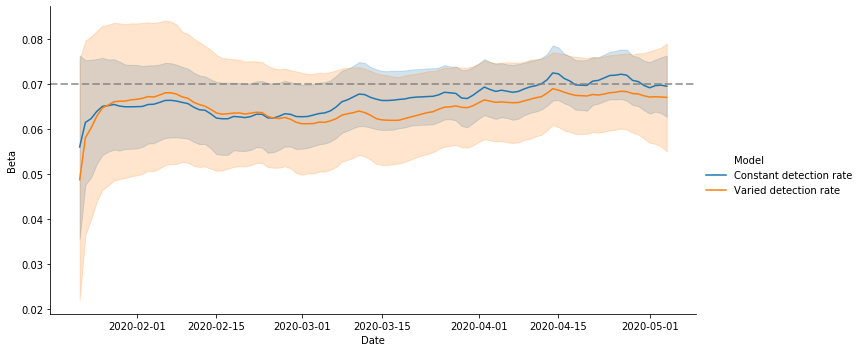

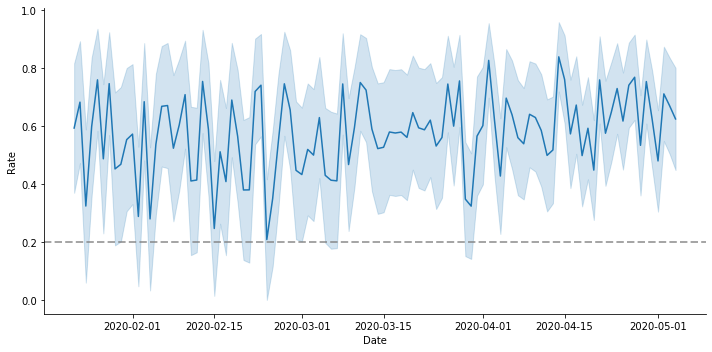

In [11]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [12]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      89.33     0.3   9.39  71.89  82.93  88.99  95.51 109.05   1007   1.01
b_beta       4.6e-3  9.8e-5 1.4e-3 2.4e-3 3.6e-3 4.4e-3 5.4e-3 7.9e-3    208   1.01
b[1]           0.05  8.6e-4   0.02 7.4e-3   0.03   0.05   0.06   0.08    554   1.01
b[2]           0.05  6.7e-4   0.02   0.02   0.04   0.05   0.06   0.08    636   1.02
b[3]           0.06  5.4e-4   0.01   0.03   0.05   0.06   0.07   0.09    736   1.01
b[4]           0.06  3.9e-4   0.01   0.04   0.05   0.06   0.07   0.09   1021   1.01
b[5]           0.07  3.7e-4   0.01   0.04   0.06   0.06   0.07   0.09    991   1.01
b[6]           0.07  3.8e-4   0.01   0.05   0.06   0.07   0.07   0.09    891   1.01
b[7]           0.06  3.9e-4   0.01   0.04   0.06   0.06

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     154.66    5.36  74.63  84.59 107.05 131.22 173.77 379.87    194   1.02
b_beta       3.5e-3  9.1e-5 1.2e-3 1.6e-3 2.6e-3 3.3e-3 4.1e-3 6.2e-3    169   1.01
b[1]           0.06  1.3e-3   0.02   0.01   0.04   0.06   0.07    0.1    291   1.02
b[2]           0.06  1.2e-3   0.02   0.02   0.05   0.06   0.08    0.1    281   1.02
b[3]           0.06  1.2e-3   0.02   0.02   0.05   0.07   0.08    0.1    274   1.01
b[4]           0.07  1.1e-3   0.02   0.03   0.06   0.07   0.08    0.1    277   1.02
b[5]           0.07  1.1e-3   0.02   0.03   0.06   0.07   0.08    0.1    268   1.02
b[6]           0.07  1.1e-3   0.02   0.03   0.06   0.07   0.08    0.1    253   1.02
b[7]           0.07  1.1e-3   0.02   0.03   0.06   0.07

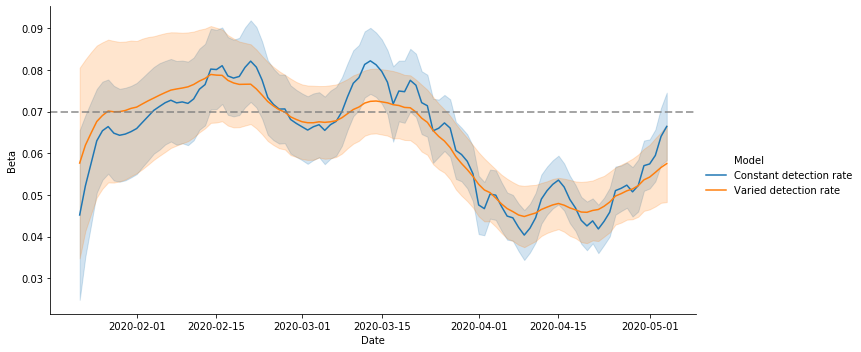

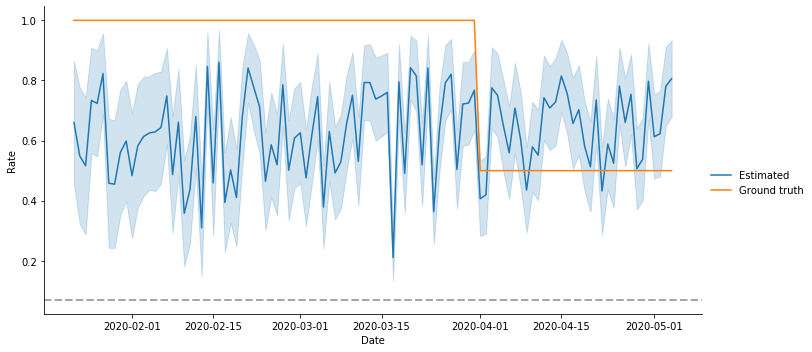

In [13]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
                     
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', line=0.07, value_name='Rate', label_name='')

In [14]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        q.append(q0 + 0.05*np.random.randn(1)[0])
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        b.append(b[-1] - b1)
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     139.32    0.34  16.37  109.4 127.76 138.44 150.25 173.89   2310    1.0
b_beta       8.0e-3  2.9e-5 1.2e-3 6.0e-3 7.2e-3 8.0e-3 8.8e-3   0.01   1632    1.0
b[1]           0.12  7.6e-4   0.03   0.06   0.11   0.13   0.14   0.17   1422    1.0
b[2]           0.13  4.9e-4   0.02   0.08   0.12   0.13   0.15   0.17   2173    1.0
b[3]           0.14  3.9e-4   0.02    0.1   0.12   0.14   0.15   0.18   2298    1.0
b[4]           0.14  3.7e-4   0.02    0.1   0.13   0.14   0.15   0.17   2166    1.0
b[5]           0.14  3.5e-4   0.02   0.11   0.13   0.14   0.15   0.17   2224    1.0
b[6]           0.14  3.3e-4   0.02   0.11   0.13   0.14   0.15   0.17   2244    1.0
b[7]           0.14  3.3e-4   0.02   0.11   0.13   0.14

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     136.81    1.89  48.69  75.46 102.49 127.52 159.05 259.72    660   1.01
b_beta       3.1e-3  5.5e-5 9.3e-4 1.6e-3 2.5e-3 3.0e-3 3.7e-3 5.3e-3    291   1.01
b[1]           0.12  7.6e-4   0.02   0.07   0.11   0.12   0.14   0.16    882   1.01
b[2]           0.12  6.9e-4   0.02   0.08   0.11   0.12   0.14   0.16   1010   1.01
b[3]           0.12  6.8e-4   0.02   0.08   0.11   0.12   0.14   0.16    969   1.01
b[4]           0.12  6.8e-4   0.02   0.08   0.11   0.12   0.14   0.16    921   1.01
b[5]           0.12  6.9e-4   0.02   0.08   0.11   0.13   0.14   0.16    828   1.01
b[6]           0.13  6.9e-4   0.02   0.09   0.11   0.13   0.14   0.16    768   1.01
b[7]           0.13  6.8e-4   0.02   0.09   0.11   0.13

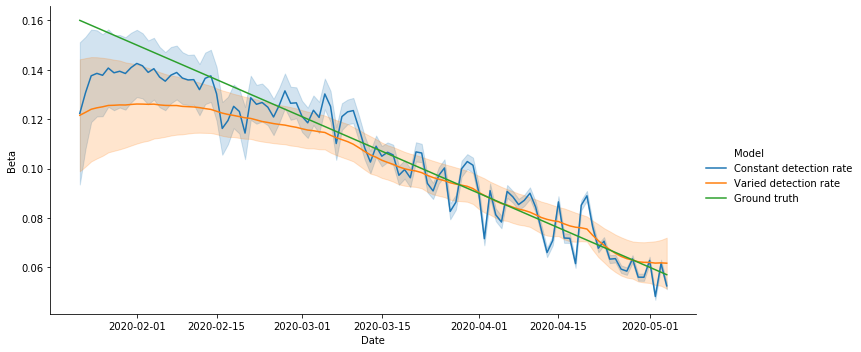

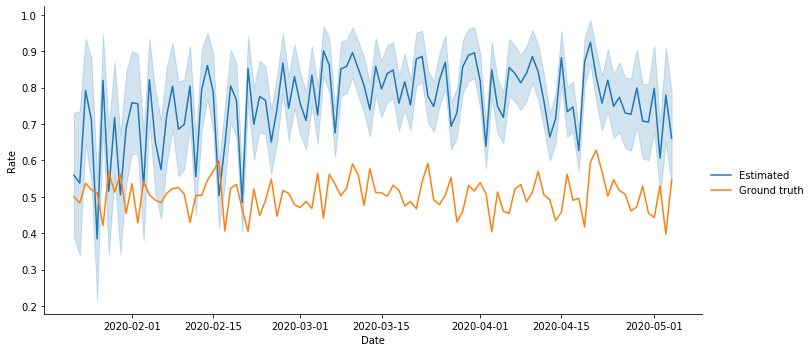

In [15]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
b = extract_var('b', infered_every)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

In [16]:
#### Satulate ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.30, 0.2, 100, 0.04, 0.001, 12000_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.88     1.5   2.12   0.15   0.33   0.93   3.56   5.53      2 117.41
b_beta         1.37    1.26   1.79   0.24   0.26   0.36   2.55    4.6      2  55.41
b[1]           2.84    1.13    1.6   0.55   1.25   3.18   4.29   4.54      2  45.66
b[2]           2.11    0.87   1.23   0.76   1.08   1.82   3.15   4.12      2  54.77
b[3]           1.32    0.67   0.94   0.35   0.48   1.08   2.21    2.8      2  88.73
b[4]           0.45    0.22   0.32   0.19   0.22   0.31   0.71    1.0      2  98.24
b[5]           1.91    1.83   2.59   0.14   0.28   0.55   3.52   6.53      2  37.68
b[6]           1.77    0.72   1.02   0.51   0.81   1.63   2.67    3.3      2  56.02
b[7]           1.65    0.39   0.55   0.92   1.16   1.58

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      28.29    0.86   8.04  16.68  22.76  27.15  32.38  47.07     87   1.04
b_beta       3.7e-3  5.7e-4 1.5e-3 1.2e-3 2.6e-3 3.5e-3 4.6e-3 7.1e-3      7   1.29
b[1]           0.28  5.6e-3   0.04   0.14   0.27   0.29    0.3   0.33     45   1.09
b[2]           0.29  2.1e-3   0.02   0.24   0.28   0.29    0.3   0.33    123   1.02
b[3]           0.29  2.0e-3   0.02   0.24   0.28   0.29    0.3   0.33    119   1.03
b[4]           0.29  1.9e-3   0.02   0.24   0.28   0.29    0.3   0.33    115   1.03
b[5]           0.29  1.9e-3   0.02   0.25   0.28   0.29    0.3   0.33    112   1.03
b[6]           0.29  1.8e-3   0.02   0.25   0.28   0.29    0.3   0.33    108   1.03
b[7]           0.29  1.8e-3   0.02   0.25   0.28   0.29

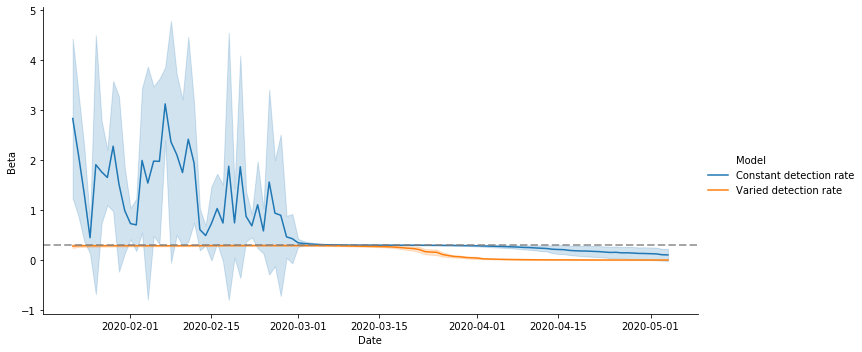

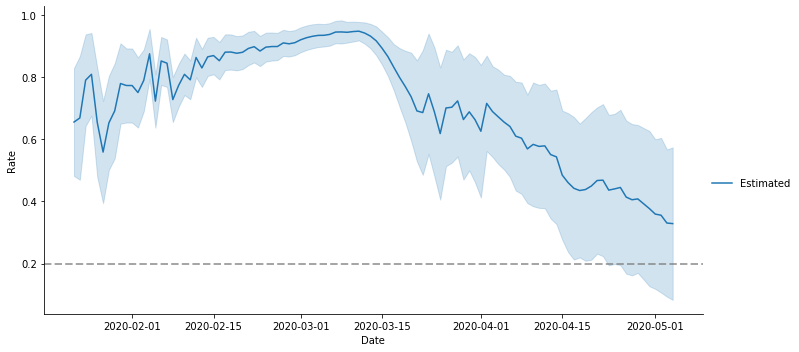

In [17]:
beta_const_q = extract_var('b', infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.30, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', value_name='Rate', label_name='')

In [18]:
## Analysis ##
iteration = 10000

In [19]:
### Japanese case ###
P = 126_500_000
infer_const = fit_and_infer(sm=sm_const, country='Japan', population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country='Japan', population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}))

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      14.18    0.02   3.47   8.08  11.74  13.94  16.36  21.66  22980    1.0
b              0.09  5.5e-6 8.0e-4   0.09   0.09   0.09   0.09   0.09  21541    1.0
q               1.0  2.7e-6 4.7e-4    1.0    1.0    1.0    1.0    1.0  30883    1.0
NI[1]          1.36  5.9e-3   0.84   0.09    0.7   1.27   1.91   3.23  20531    1.0
NI[2]          1.45  6.1e-3   0.88   0.11   0.77   1.35    2.0   3.42  21142    1.0
NI[3]          1.53  6.7e-3   0.92    0.1   0.82   1.44   2.11   3.55  18864    1.0
NI[4]          2.56  6.0e-3   0.93   0.91    1.9    2.5   3.15   4.56  24037    1.0
NI[5]          1.73  7.1e-3   1.01   0.14   0.95   1.63    2.4   3.93  20297    1.0
NI[6]          3.17  6.8e-3   1.02   1.37   2.43    3

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.64    0.01   0.86   0.46   1.02   1.48   2.09   3.79   4306    1.0
b_beta         0.06  1.2e-4 7.3e-3   0.05   0.06   0.06   0.07   0.08   3421   1.01
b[1]           0.09  1.0e-3   0.08 3.7e-3   0.03   0.07   0.12    0.3   5916    1.0
b[2]           0.14  1.4e-3   0.09   0.01   0.07   0.13   0.19   0.37   4213    1.0
b[3]           0.19  2.0e-3    0.1   0.03   0.11   0.17   0.24   0.42   2450    1.0
b[4]           0.23  2.1e-3    0.1   0.07   0.16   0.22   0.29   0.45   2207    1.0
b[5]           0.24  2.5e-3    0.1   0.07   0.17   0.23    0.3   0.47   1666    1.0
b[6]           0.27  2.1e-3    0.1    0.1    0.2   0.26   0.32   0.48   2048    1.0
b[7]           0.26  1.9e-3    0.1    0.1   0.19   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.67    0.12   5.75   1.14   2.58   4.01   6.65  20.18   2488    1.0
b_beta         0.01  1.1e-4 3.9e-3 8.1e-3   0.01   0.01   0.02   0.02   1183   1.01
b[1]           0.07  2.0e-3   0.07 1.7e-3   0.02   0.04   0.11   0.23   1081    1.0
b[2]            0.1  1.6e-3   0.07 7.8e-3   0.04   0.09   0.15   0.25   1901    1.0
b[3]           0.13  1.2e-3   0.06   0.02   0.08   0.12   0.17   0.26   3035    1.0
b[4]           0.15  8.4e-4   0.06   0.05    0.1   0.14   0.18   0.27   4881    1.0
b[5]           0.15  7.9e-4   0.06   0.06   0.12   0.15   0.19   0.27   4890    1.0
b[6]           0.16  7.6e-4   0.05   0.07   0.13   0.16   0.19   0.28   4723    1.0
b[7]           0.16  7.2e-4   0.05   0.08   0.13   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  4338.24   724.43
p_loo   1097.87        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       30   28.6%
 (0.5, 0.7]   (ok)         22   21.0%
   (0.7, 1]   (bad)        13   12.4%
   (1, Inf)   (very bad)   40   38.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   759.61    29.11
p_loo     92.29        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7    6.7%
 (0.5, 0.7]   (ok)         17   16.2%
   (0.7, 1]   (bad)        67   63.8%
   (1, Inf)   (very bad)   14   13.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   748.12    29.02
p_loo     89.05        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        6    5.7%
 (0.5, 0.7]   (ok)          9    8.6%
   (0.7, 1]   (bad)        83   79.0%
   (1, Inf)   (very bad)    7    6.7%

         rank     waic   p_waic   d_waic     weight       se      dse warning  \
Varied_q    0  678.006  53.9928        0   0.974164  1026.75        0    True   
Const_q     1  687.927  56.4456   9.9212  0.0258357  27.6277  3.63362    True   
Const       2  5150.65  1504.08  4472.64          0   28.231  980.854    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


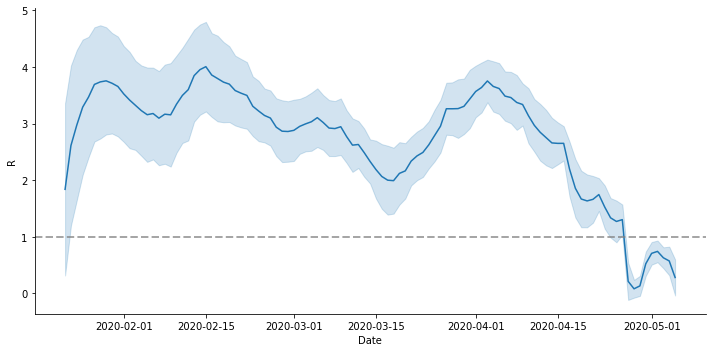

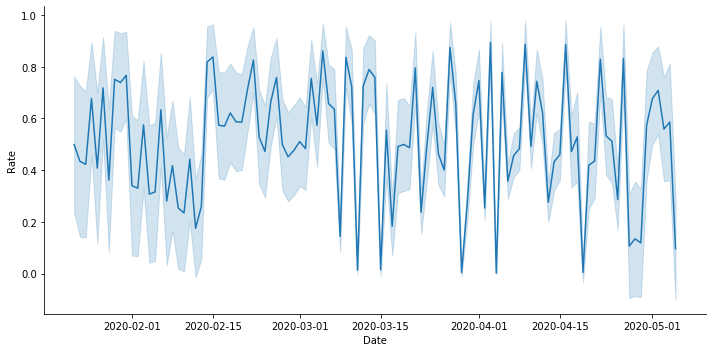

In [20]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_J = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [21]:
### China ###
P = 1_393_000_000
country='China'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     6494.6     0.5  83.72 6331.3 6438.2 6495.2 6550.4 6659.4  27853    1.0
b              0.06  1.7e-6 2.7e-4   0.06   0.06   0.06   0.06   0.06  26048    1.0
q               1.0  2.3e-7 3.9e-5    1.0    1.0    1.0    1.0    1.0  28064    1.0
NI[1]        451.94    0.09  17.81 417.27 439.98 451.84 463.95 487.24  35358    1.0
NI[2]        575.89    0.09  16.86 542.97 564.39 575.94 587.22 608.78  33885    1.0
NI[3]        689.84    0.09  16.73 657.27 678.38 689.74 701.13 722.92  36332    1.0
NI[4]         783.5    0.09  16.96 750.32  771.9 783.54 795.05 817.15  35430    1.0
NI[5]        857.02    0.09  17.28 823.16 845.38 856.92  868.8 891.24  35648    1.0
NI[6]        1346.2    0.09  17.33 1312.2 1334.5 1346

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     556.42    0.16   23.0 512.32 540.78 556.15 571.76 602.37  20267    1.0
b_beta       7.1e-3  8.0e-6 1.3e-3 5.0e-3 6.2e-3 7.0e-3 7.9e-3 9.9e-3  25255    1.0
b[1]           0.17  1.6e-4   0.03   0.12   0.15   0.17   0.19   0.23  28309    1.0
b[2]           0.48  1.7e-4   0.02   0.44   0.46   0.48   0.49   0.52  14433    1.0
b[3]           0.48  1.6e-4   0.02   0.45   0.47   0.48   0.49   0.52  13204    1.0
b[4]           0.48  1.5e-4   0.02   0.44   0.46   0.48   0.49   0.51  13922    1.0
b[5]           0.46  1.7e-4   0.02   0.42   0.45   0.46   0.48    0.5  13789    1.0
b[6]           0.98  2.1e-4   0.03   0.92   0.96   0.98    1.0   1.05  25241    1.0
b[7]           0.11  4.1e-5 6.7e-3    0.1   0.11   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     9825.0   30.16 1424.4 7481.7 8872.0 9668.8  1.1e4  1.3e4   2230    1.0
b_beta       1.1e-3  6.5e-6 2.7e-4 7.1e-4 9.6e-4 1.1e-3 1.3e-3 1.8e-3   1746   1.01
b[1]           0.16  1.9e-4   0.01   0.14   0.16   0.16   0.17   0.18   2716    1.0
b[2]           0.16  1.9e-4 9.9e-3   0.14   0.16   0.16   0.17   0.18   2640    1.0
b[3]           0.16  1.9e-4 9.9e-3   0.14   0.16   0.16   0.17   0.18   2591    1.0
b[4]           0.16  2.0e-4 9.8e-3   0.15   0.16   0.16   0.17   0.18   2476    1.0
b[5]           0.16  2.0e-4 9.7e-3   0.15   0.16   0.16   0.17   0.18   2380    1.0
b[6]           0.16  2.0e-4 9.6e-3   0.15   0.16   0.16   0.17   0.18   2293    1.0
b[7]           0.16  2.0e-4 9.4e-3   0.15   0.16   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 40199.97  17969.16
p_loo   3776.53        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         7    6.7%
   (1, Inf)   (very bad)   97   92.4%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   973.16    24.22
p_loo     98.78        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          5    4.8%
   (0.7, 1]   (bad)        81   77.1%
   (1, Inf)   (very bad)   19   18.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   950.65    22.86
p_loo     89.80        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)       100   95.2%
   (1, Inf)   (very bad)    4    3.8%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,873.535,51.2397,0,0.9966,25150.8,0,True,deviance
Const_q,1,888.729,56.5632,15.1941,0.00339963,23.5476,5.24535,True,deviance
Const,2,55923.1,11638.1,55049.5,0,22.4536,26612.6,True,deviance


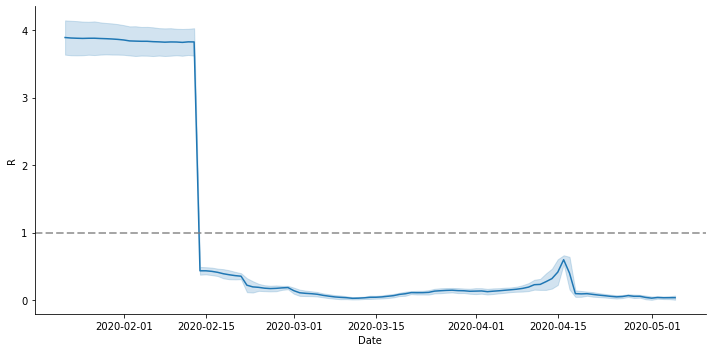

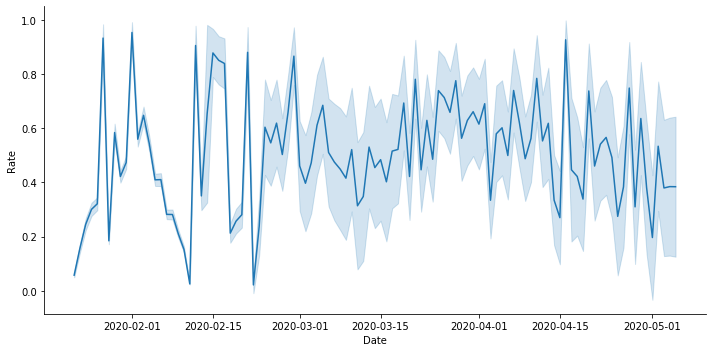

In [22]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_C = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [23]:
### US ###
P = 327_200_000
country='US'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     205.29    0.09  15.24 176.49 194.95 204.98 215.69  235.4  26872    1.0
b              0.09  6.3e-7 9.2e-5   0.09   0.09   0.09   0.09   0.09  21033    1.0
q               1.0  9.4e-8 1.6e-5    1.0    1.0    1.0    1.0    1.0  27451    1.0
NI[1]         19.22    0.03   4.12  11.23   16.4  19.22   22.0   27.3  23632    1.0
NI[2]         21.82    0.03   4.22  13.66  18.95  21.79  24.64  30.18  27679    1.0
NI[3]         22.86    0.03   4.33  14.37  19.96  22.88  25.74  31.33  25195    1.0
NI[4]         27.14    0.03   4.34  18.76  24.21   27.1  30.08  35.76  28883    1.0
NI[5]         27.26    0.03   4.54  18.48  24.12  27.22  30.31  36.13  27875    1.0
NI[6]          29.7    0.03   4.78  20.42  26.45  29.

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.44  6.5e-3   0.81   0.34   0.87   1.28   1.84   3.41  15351    1.0
b_beta         0.03  5.8e-5 5.2e-3   0.02   0.03   0.03   0.03   0.04   8074    1.0
b[1]           0.06  4.6e-4   0.05 2.9e-3   0.02   0.05   0.08    0.2  12561    1.0
b[2]            0.1  5.5e-4   0.06   0.02   0.06   0.09   0.13   0.24  10791    1.0
b[3]           0.11  5.9e-4   0.06   0.02   0.07   0.11   0.15   0.25  10012    1.0
b[4]           0.13  5.8e-4   0.06   0.04   0.09   0.13   0.16   0.26   9769    1.0
b[5]           0.13  6.7e-4   0.06   0.03   0.09   0.12   0.16   0.26   8117    1.0
b[6]           0.13  6.8e-4   0.06   0.03   0.08   0.12   0.16   0.26   7871    1.0
b[7]           0.13  6.7e-4   0.06   0.03   0.09   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       3.05    0.03   2.53   0.64   1.54   2.38    3.7   9.69   5946    1.0
b_beta         0.02  9.2e-5 3.8e-3   0.01   0.01   0.02   0.02   0.02   1707    1.0
b[1]           0.05  6.1e-4   0.05 2.2e-3   0.02   0.04   0.08   0.18   6610    1.0
b[2]           0.08  6.5e-4   0.05   0.01   0.05   0.07   0.11   0.21   6150    1.0
b[3]            0.1  6.8e-4   0.05   0.02   0.06   0.09   0.13   0.21   5370    1.0
b[4]           0.11  6.7e-4   0.05   0.04   0.08    0.1   0.14   0.22   5002    1.0
b[5]           0.11  6.9e-4   0.05   0.04   0.08   0.11   0.14   0.22   4711    1.0
b[6]           0.11  6.8e-4   0.05   0.04   0.08   0.11   0.14   0.22   4707    1.0
b[7]           0.12  6.7e-4   0.05   0.04   0.09   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 119917.78  12095.50
p_loo  12011.15        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         4    3.8%
   (1, Inf)   (very bad)   99   94.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1062.35    67.76
p_loo    112.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   19.0%
 (0.5, 0.7]   (ok)         14   13.3%
   (0.7, 1]   (bad)        53   50.5%
   (1, Inf)   (very bad)   18   17.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1003.91    59.02
p_loo     88.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       18   17.1%
 (0.5, 0.7]   (ok)          8    7.6%
   (0.7, 1]   (bad)        70   66.7%
   (1, Inf)   (very bad)    9    8.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,940.029,56.3569,0,0.999997,20274,0,True,deviance
Const_q,1,984.152,73.1505,44.1225,2.72786e-06,57.0593,15.4235,True,deviance
Const,2,180911,42507.5,179970,0,53.0681,19940.5,True,deviance


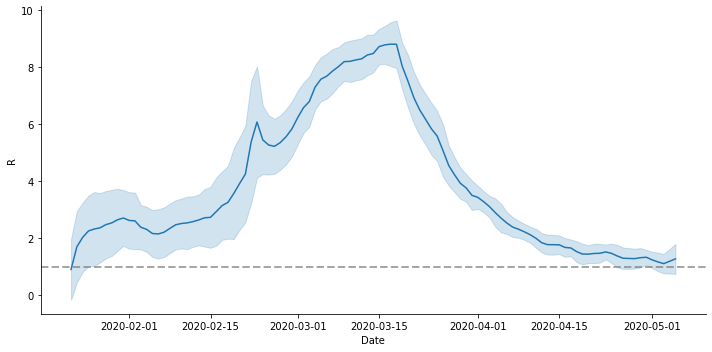

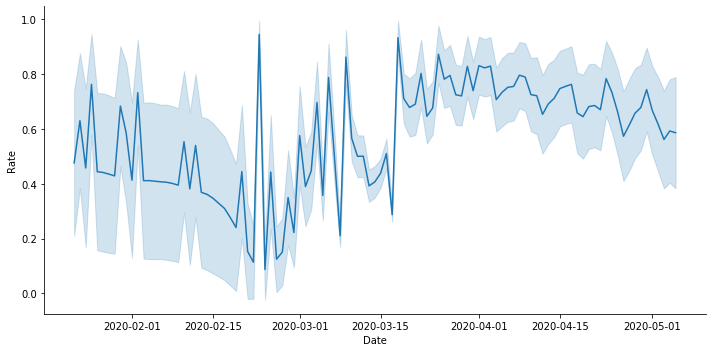

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
d = extract_var(var_name='d', data=infer)
R_US = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [25]:
### Italy ###
P = 60_360_000
country='Italy'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    656.76     0.2  28.14 602.69 637.43 656.49 675.66 712.16  19925    1.0
b             0.08  1.3e-6 1.9e-4   0.08   0.08   0.08   0.08   0.08  20716    1.0
q              1.0  3.4e-7 5.0e-5    1.0    1.0    1.0    1.0    1.0  22204    1.0
NI[1]        53.22    0.05   6.96  39.69  48.52  53.26  57.86  66.71  20943    1.0
NI[2]        57.37    0.05   7.03  43.71  52.57  57.39  62.17  71.19  21388    1.0
NI[3]        61.76    0.05   7.22  47.52  56.98  61.72  66.64  75.92  20534    1.0
NI[4]         66.7    0.05   7.26  52.48  61.83  66.66  71.58   81.0  20553    1.0
NI[5]        71.88    0.05   7.49  57.22  66.84  71.89  76.91  86.72  20679    1.0
NI[6]        78.24    0.05   7.53  63.72   73.1  78.21  83.34 

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.71    0.02   0.95   0.42   1.03   1.52   2.16   4.08   2113    1.0
b_beta        0.02  1.5e-4 2.9e-3   0.01   0.01   0.02   0.02   0.02    387   1.02
b[1]          0.03  3.4e-4   0.02 1.2e-3 9.6e-3   0.02   0.03   0.09   4557    1.0
b[2]          0.04  5.6e-4   0.03 3.4e-3   0.02   0.03   0.05   0.11   2698    1.0
b[3]          0.05  7.4e-4   0.03 6.2e-3   0.03   0.05   0.07   0.13   1925    1.0
b[4]          0.06  8.6e-4   0.03 9.1e-3   0.04   0.06   0.08   0.14   1647    1.0
b[5]          0.07  1.0e-3   0.04   0.01   0.04   0.06   0.09   0.16   1274   1.01
b[6]          0.08  1.1e-3   0.04   0.02   0.05   0.07    0.1   0.16   1186   1.01
b[7]          0.08  1.4e-3   0.04   0.01   0.05   0.08    0.1 

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      2.28    0.03   1.95   0.45   1.15   1.81   2.78   6.95   3732    1.0
b_beta        0.01  8.8e-5 3.2e-3 6.5e-3 9.5e-3   0.01   0.01   0.02   1304    1.0
b[1]          0.04  2.2e-3   0.07 8.2e-4 7.7e-3   0.02   0.04   0.29    932    1.0
b[2]          0.07  3.1e-3   0.08 2.8e-3   0.02   0.03   0.07   0.34    771    1.0
b[3]          0.09  3.3e-3    0.1 5.4e-3   0.03   0.05    0.1   0.37    807   1.01
b[4]          0.11  3.9e-3   0.11 9.0e-3   0.04   0.07   0.14   0.39    744   1.01
b[5]          0.13  3.9e-3   0.11   0.01   0.05   0.09   0.18    0.4    813   1.01
b[6]          0.15  3.9e-3   0.12   0.02   0.06   0.11   0.23   0.42    881   1.01
b[7]          0.17  4.0e-3   0.12   0.02   0.07   0.13   0.26 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo 35086.34  3923.51
p_loo   5563.16        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.1%
 (0.5, 0.7]   (ok)          2    2.1%
   (0.7, 1]   (bad)         6    6.3%
   (1, Inf)   (very bad)   86   90.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   941.95    46.18
p_loo     84.10        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   21.1%
 (0.5, 0.7]   (ok)          5    5.3%
   (0.7, 1]   (bad)        59   62.1%
   (1, Inf)   (very bad)   11   11.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   931.61    40.39
p_loo     80.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        9    9.5%
 (0.5, 0.7]   (ok)          4    4.2%
   (0.7, 1]   (bad)        75   78.9%
   (1, Inf)   (very bad)    7    7.4%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,865.393,47.0225,0,0.69168,5984.02,0,True,deviance
Const_q,1,872.329,49.2868,6.93686,0.30832,41.2092,12.2387,True,deviance
Const,2,47591,11815.5,46725.6,0,38.8106,5918.19,True,deviance


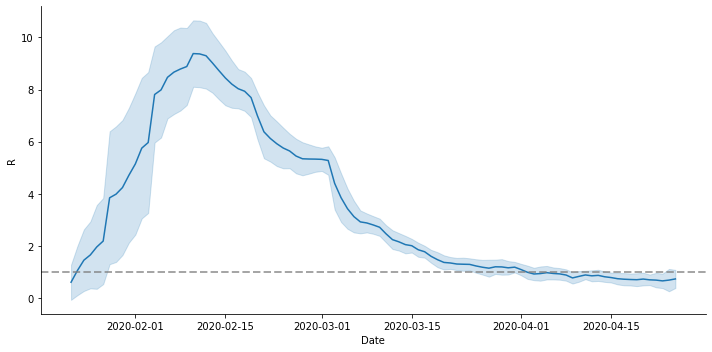

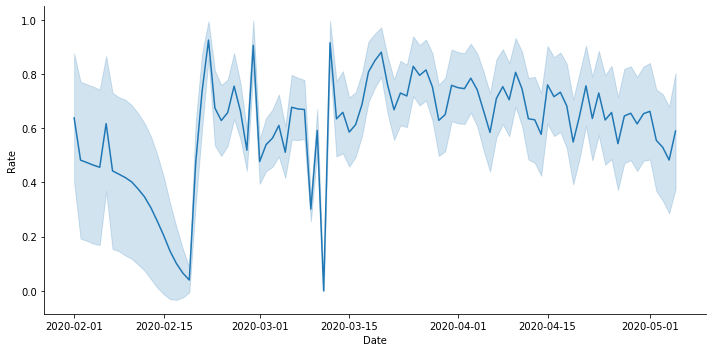

In [26]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
d = extract_var(var_name='d', data=infer, start=start)
R_I = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [27]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     139.64    0.07  13.42  114.4 130.34 139.27 148.57  166.8  34893    1.0
b              0.06  3.9e-6 7.2e-4   0.06   0.06   0.06   0.06   0.07  33703    1.0
q               1.0  2.1e-6 3.5e-4    1.0    1.0    1.0    1.0    1.0  29615    1.0
NI[1]          9.21    0.02   2.88   3.55   7.23   9.19  11.11  14.89  22874    1.0
NI[2]         10.63    0.02   2.83   5.19    8.7  10.58  12.49  16.27  31037    1.0
NI[3]         10.38    0.02   3.02   4.47   8.33  10.39  12.41  16.28  25952    1.0
NI[4]         11.84    0.02   2.97   6.05   9.81  11.81  13.85  17.72  28894    1.0
NI[5]         12.52    0.02   2.98   6.65  10.49   12.5  14.52  18.45  30192    1.0
NI[6]         12.55    0.02   3.15   6.35   10.4  12.

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.47    0.02   1.36   0.65    1.5    2.2   3.15   5.85   7313    1.0
b_beta       9.1e-3  2.7e-5 1.7e-3 6.1e-3 7.9e-3 8.9e-3   0.01   0.01   4001    1.0
b[1]           0.06  1.2e-3   0.06 1.3e-3   0.01   0.04    0.1   0.19   2184    1.0
b[2]           0.09  1.0e-3   0.05   0.01   0.05   0.09   0.13    0.2   2659    1.0
b[3]            0.1  9.5e-4   0.05   0.02   0.07    0.1   0.13   0.21   2686    1.0
b[4]           0.11  8.5e-4   0.04   0.03   0.08   0.11   0.14   0.21   2771    1.0
b[5]           0.12  7.9e-4   0.04   0.04   0.09   0.11   0.14   0.21   2865    1.0
b[6]           0.12  7.4e-4   0.04   0.05   0.09   0.12   0.15   0.21   3039    1.0
b[7]           0.13  6.9e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.44    0.03   0.88   0.33   0.85   1.26   1.82   3.56    814   1.01
b_beta       2.8e-3  1.2e-4 1.1e-3 1.1e-3 2.0e-3 2.7e-3 3.4e-3 5.5e-3     87   1.05
b[1]           0.15    0.07   0.13 1.1e-4 2.7e-3   0.23   0.27   0.31      4   1.59
b[2]           0.26  2.3e-3   0.04   0.18   0.25   0.26   0.28   0.31    249   1.02
b[3]           0.26  2.2e-3   0.04   0.18   0.25   0.26   0.28   0.31    254   1.02
b[4]           0.26  2.1e-3   0.03   0.19   0.25   0.27   0.28   0.31    217   1.02
b[5]           0.26  2.0e-3   0.03   0.19   0.25   0.27   0.28   0.31    214   1.02
b[6]           0.26  2.0e-3   0.03   0.19   0.25   0.27   0.28   0.31    213   1.02
b[7]           0.26  2.0e-3   0.03   0.19   0.25   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  7018.32  1227.87
p_loo   1365.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3    2.9%
 (0.5, 0.7]   (ok)          7    6.7%
   (0.7, 1]   (bad)        26   24.8%
   (1, Inf)   (very bad)   69   65.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   771.53    39.57
p_loo     94.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       16   15.2%
 (0.5, 0.7]   (ok)         18   17.1%
   (0.7, 1]   (bad)        58   55.2%
   (1, Inf)   (very bad)   13   12.4%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   740.93    27.05
p_loo     87.01        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7    6.7%
 (0.5, 0.7]   (ok)          5    4.8%
   (0.7, 1]   (bad)        82   78.1%
   (1, Inf)   (very bad)   11   10.5%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,672.14,52.6109,0,0.995768,1518.29,0,True,deviance
Const_q,1,714.717,65.7983,42.5775,0.00423163,37.7943,25.1458,True,deviance
Const,2,7719.63,1716.3,7047.49,0,24.6912,1499.88,True,deviance


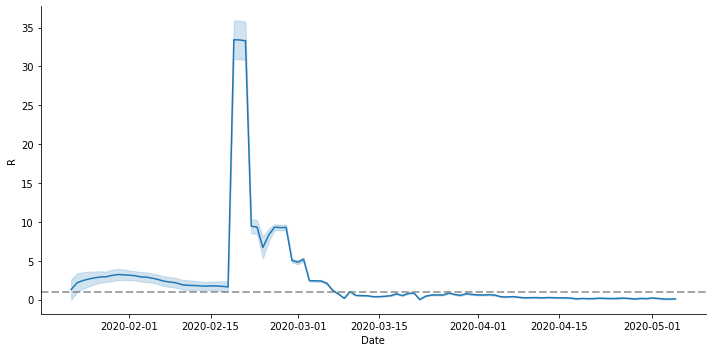

In [28]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

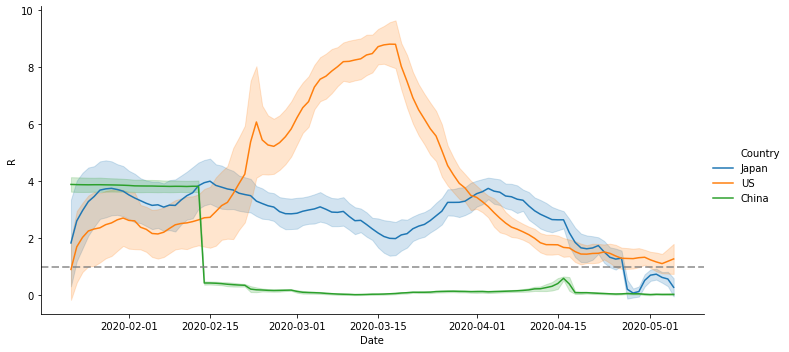

In [29]:
draw({'Japan':R_J, 'US':R_US, 'China':R_C}, line=1, name='R_multi', value_name='R', label_name='Country')

In [30]:
### Sweden ###
P = 10_230_000
country='Sweden'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     17.18    0.02   4.32   9.55  14.13  16.84  19.95  26.54  30828    1.0
b             0.09  4.3e-6 6.8e-4   0.09   0.09   0.09   0.09   0.09  24942    1.0
q              1.0  5.8e-6 1.1e-3    1.0    1.0    1.0    1.0    1.0  34047    1.0
NI[1]         1.75  7.3e-3   1.03   0.13   0.97   1.66   2.41   4.02  19791    1.0
NI[2]         1.87  7.7e-3   1.07   0.17   1.05   1.77   2.57   4.19  19500    1.0
NI[3]         2.01  8.1e-3    1.1    0.2   1.19   1.93   2.73   4.36  18344    1.0
NI[4]         2.15  8.5e-3   1.15   0.23    1.3   2.07    2.9   4.58  17987    1.0
NI[5]         2.33  8.7e-3   1.22   0.27   1.42   2.25   3.14    4.9  19476    1.0
NI[6]         2.52  8.9e-3   1.27   0.34   1.58   2.44   3.36 

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      0.66  3.7e-3   0.48   0.07   0.31   0.55   0.89   1.88  16687    1.0
b_beta        0.03  4.9e-5 4.4e-3   0.02   0.02   0.03   0.03   0.04   7863    1.0
b[1]          0.03  2.2e-4   0.03 1.3e-3   0.01   0.02   0.04   0.11  16289    1.0
b[2]          0.05  3.0e-4   0.03 3.1e-3   0.02   0.04   0.07   0.14  13090    1.0
b[3]          0.06  3.9e-4   0.04 4.6e-3   0.03   0.05   0.08   0.15  10078    1.0
b[4]          0.06  4.5e-4   0.04 5.4e-3   0.03   0.06   0.09   0.16   8511    1.0
b[5]          0.07  4.9e-4   0.04 6.5e-3   0.04   0.06   0.09   0.17   7859    1.0
b[6]          0.07  5.4e-4   0.05 7.8e-3   0.04   0.07    0.1   0.18   7129    1.0
b[7]          0.08  5.6e-4   0.05 8.3e-3   0.04   0.07    0.1 

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.22  8.2e-3    0.9   0.17   0.61    1.0   1.59   3.55  12043    1.0
b_beta        0.01  8.1e-5 3.6e-3 8.3e-3   0.01   0.01   0.02   0.02   2006    1.0
b[1]          0.02  2.7e-4   0.02 8.8e-4 8.0e-3   0.02   0.03   0.09   8075    1.0
b[2]          0.04  3.6e-4   0.03 2.9e-3   0.02   0.03   0.05   0.12   6839    1.0
b[3]          0.05  4.5e-4   0.03 4.8e-3   0.02   0.04   0.06   0.13   5531    1.0
b[4]          0.06  5.1e-4   0.04 7.0e-3   0.03   0.05   0.08   0.15   5072    1.0
b[5]          0.07  5.8e-4   0.04 9.9e-3   0.04   0.06   0.09   0.16   4425    1.0
b[6]          0.07  6.2e-4   0.04   0.01   0.04   0.07    0.1   0.17   4286    1.0
b[7]          0.08  6.9e-4   0.04   0.01   0.05   0.07    0.1 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo  2836.57   306.66
p_loo    629.40        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       14   14.7%
 (0.5, 0.7]   (ok)         23   24.2%
   (0.7, 1]   (bad)        25   26.3%
   (1, Inf)   (very bad)   33   34.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   759.72    50.29
p_loo     91.91        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   28.4%
 (0.5, 0.7]   (ok)          4    4.2%
   (0.7, 1]   (bad)        59   62.1%
   (1, Inf)   (very bad)    5    5.3%

Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   685.45    39.88
p_loo     65.28        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       21   22.1%
 (0.5, 0.7]   (ok)          5    5.3%
   (0.7, 1]   (bad)        64   67.4%
   (1, Inf)   (very bad)    5    5.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,633.752,39.4252,0,1,366.874,0,True,deviance
Const_q,1,705.272,64.6857,71.5202,1.55686e-07,47.1302,26.9428,True,deviance
Const,2,2920.65,671.438,2286.9,0,36.3143,346.789,True,deviance


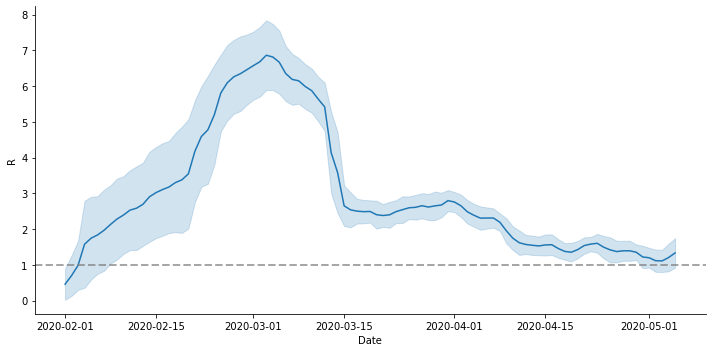

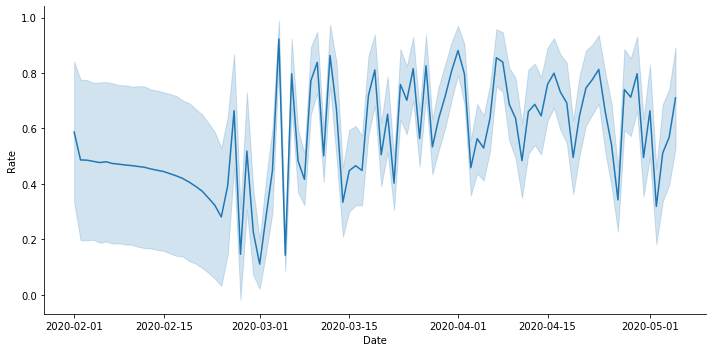

In [31]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
d = extract_var(var_name='d', data=infer, start=start)
R_S = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_S}, line=1, name='R_Sweden', value_name='R')
draw({'Detection rate':q}, name='q_Sweden', value_name='Rate')

In [32]:
### Denmark ###
P = 5_806_000
country='Denmark'
start=pd.to_datetime('2020-03-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_e016c2803a6aaef99e20fd9e9c81e7a9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    249.56    0.12  16.37 218.32 238.45 249.23  260.5 282.51  17783    1.0
b             0.07  6.5e-6 8.7e-4   0.07   0.07   0.07   0.08   0.08  18011    1.0
q              1.0  9.7e-6 1.6e-3   0.99    1.0    1.0    1.0    1.0  26348    1.0
NI[1]         19.0    0.03   4.14  10.97  16.17  18.98  21.79  27.07  20044    1.0
NI[2]        22.08    0.03   4.02  14.38  19.32  22.01   24.8  30.04  21980    1.0
NI[3]        25.64    0.03   4.04  17.82   22.9  25.63  28.36  33.76  22611    1.0
NI[4]        23.59    0.03   4.43  14.96  20.61  23.55  26.59  32.28  22009    1.0
NI[5]        33.24    0.03   4.05  25.38  30.49  33.21  35.94  41.27  22759    1.0
NI[6]        27.16    0.03   4.62  18.09  24.11  27.19  30.21 

Inference for Stan model: anon_model_480ac5eb816fc9bbcdd0b556dd97733b.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      3.34    0.05   1.81   0.87   2.01    3.0   4.28   7.74   1153    1.0
b_beta        0.02  7.7e-5 3.3e-3   0.01   0.01   0.02   0.02   0.02   1828    1.0
b[1]          0.24    0.02   0.28 1.3e-3   0.01    0.1    0.4   0.98    339   1.01
b[2]           0.5    0.02    0.3   0.05    0.3   0.43   0.62   1.22    306   1.01
b[3]          0.54    0.02   0.29   0.15   0.33   0.45   0.66   1.26    302   1.01
b[4]          0.54    0.02   0.29   0.16   0.34   0.46   0.66   1.26    290   1.01
b[5]          0.57    0.02   0.31   0.19   0.36   0.47    0.7   1.34    243   1.01
b[6]          0.57    0.02   0.31   0.19   0.35   0.47   0.71   1.34    242   1.01
b[7]          0.93    0.06   0.49    0.3   0.47   0.88   1.37 

Inference for Stan model: anon_model_b305bf3606a6c594794b11744bb1397a.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      5.27     0.1   3.51   1.55   3.06   4.41   6.36  14.73   1145   1.01
b_beta      9.2e-3  1.1e-4 3.0e-3 4.7e-3 7.1e-3 8.8e-3   0.01   0.02    718    1.0
b[1]          0.26    0.07   0.33 5.3e-4 5.5e-3   0.02   0.65   0.83     22   1.25
b[2]          0.72  4.7e-3    0.1   0.51   0.65   0.71   0.78   0.93    488   1.01
b[3]          0.72  4.6e-3    0.1   0.52   0.65   0.72   0.78   0.93    485   1.01
b[4]          0.72  4.6e-3    0.1   0.52   0.65   0.72   0.78   0.93    477   1.01
b[5]          0.72  4.6e-3    0.1   0.53   0.66   0.72   0.78   0.93    465   1.01
b[6]          0.72  4.6e-3    0.1   0.53   0.66   0.72   0.78   0.93    465   1.01
b[7]          0.72  4.6e-3    0.1   0.53   0.66   0.72   0.78 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo  2188.07   235.93
p_loo    478.65        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3    4.5%
 (0.5, 0.7]   (ok)         13   19.7%
   (0.7, 1]   (bad)        15   22.7%
   (1, Inf)   (very bad)   35   53.0%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo   635.33    27.56
p_loo     80.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          8   12.1%
   (0.7, 1]   (bad)        49   74.2%
   (1, Inf)   (very bad)    9   13.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo   579.26    13.10
p_loo     56.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          4    6.1%
   (0.7, 1]   (bad)        60   90.9%
   (1, Inf)   (very bad)    2    3.0%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,532.635,32.9069,0,0.999913,228.578,0,True,deviance
Const_q,1,581.009,53.4748,48.3749,8.65469e-05,20.5452,21.8632,True,deviance
Const,2,2180.71,474.975,1648.08,5.18619e-206,12.2454,246.2,True,deviance


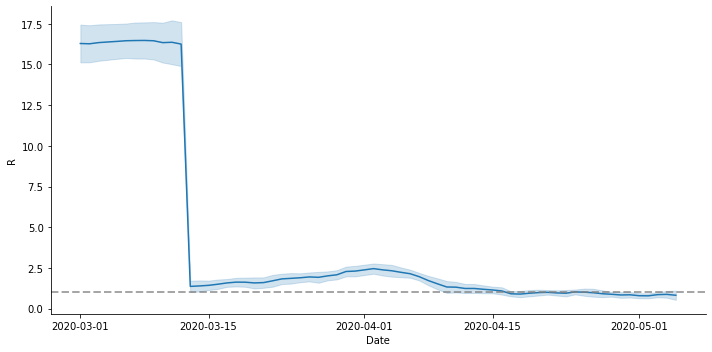

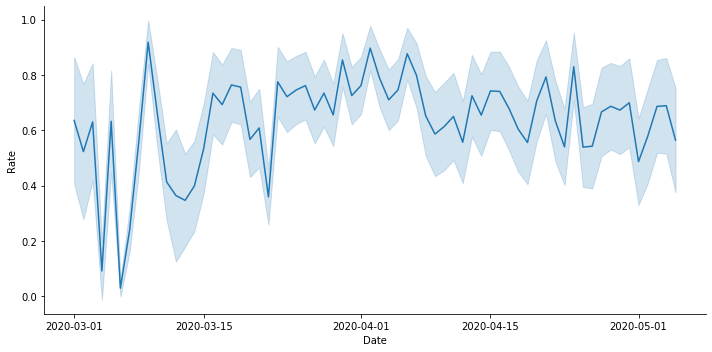

In [33]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
d = extract_var(var_name='d', data=infer, start=start)
R_D = pd.DataFrame(np.array([(beta[i].values / (d.iloc[i].values + 0.04)) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_D}, line=1, name='R_Denmark', value_name='R')
draw({'Detection rate':q}, name='q_Denmark', value_name='Rate')

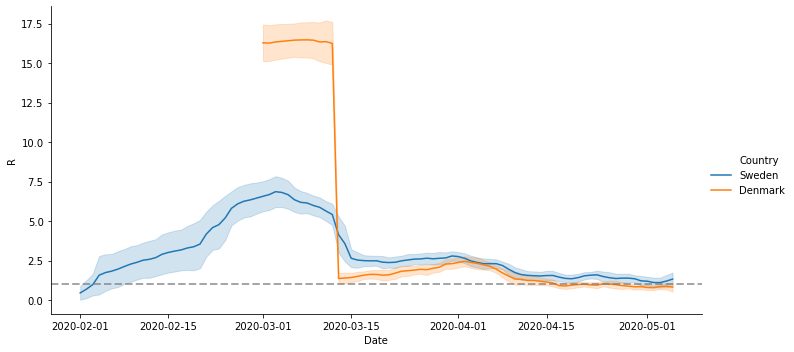

In [34]:
draw({'Sweden':R_S, 'Denmark':R_D,}, line=1, name='R_Nordic', value_name='R', label_name='Country')